# Basic Example

##  Read Image

In [1]:
import SimpleITK as sitk
import os

OUTPUT_DIR = "Output"

In [2]:
fixed_image = sitk.ReadImage("training_001_ct.mha", sitk.sitkFloat32)
moving_image = sitk.ReadImage("training_001_mr_T1.mha", sitk.sitkFloat32)

In [3]:
def image_info(img):
    print(img.GetSize())
    print(img.GetSpacing())
    print()
    
image_info(fixed_image)
image_info(moving_image)

(512, 512, 29)
(0.653595, 0.653595, 4.0)

(256, 256, 26)
(1.25, 1.25, 4.0)



## Initial Alignment

In [5]:
# 根据两个图像计算初始化Trans
initial_transform = sitk.CenteredTransformInitializer(
    fixedImage = fixed_image, 
    movingImage = moving_image, 
    transform = sitk.Euler3DTransform(),
    operationMode = sitk.CenteredTransformInitializerFilter.GEOMETRY
)
print(type(initial_transform))

<class 'SimpleITK.SimpleITK.Transform'>


In [7]:
# 对 moving image 进行转换和重采样
moving_resampled = sitk.Resample(
    image1 = moving_image,
    referenceImage = fixed_image,
    transform = initial_transform,
    interpolator = sitk.sitkLinear,
    defaultPixelValue = 0.0,
    outputPixelType = moving_image.GetPixelID(),
)
image_info(moving_image)
image_info(moving_resampled)

(256, 256, 26)
(1.25, 1.25, 4.0)

(512, 512, 29)
(0.653595, 0.653595, 4.0)



## Registration

[`sitk.ImageRegistrationMethod()`](https://simpleitk.org/doxygen/v2_1/html/classitk_1_1simple_1_1ImageRegistrationMethod.html)

In [9]:
# 声明一个helper class
registration_method = sitk.ImageRegistrationMethod()


# Similarity metric settings.
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)

registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)


# Interpolator settings
registration_method.SetInterpolator(sitk.sitkLinear)


# Oprimizer settings
registration_method.SetOptimizerAsGradientDescent(
    learningRate=1.0, 
    numberOfIterations=100, 
    convergenceMinimumValue=1e-6, 
    convergenceWindowSize=10,
)
# Estimating scales of transform parameters a step sizes, 
# from the maximum voxel shift in physical space caused by a parameter change. 
registration_method.SetOptimizerScalesFromPhysicalShift()


# Setup for the multi-resolution framwork
registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()


# Set initial transform
registration_method.SetInitialTransform(initial_transform, inPlace=False)

In [10]:
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations

    metric_values = []
    multires_iterations = []


# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations

    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()


# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations

    metric_values.append(registration_method.GetMetricValue())
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, "r")
    plt.plot(
        multires_iterations,
        [metric_values[index] for index in multires_iterations],
        "b*",
    )
    plt.xlabel("Iteration Number", fontsize=12)
    plt.ylabel("Metric Value", fontsize=12)
    plt.show()


# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the
# metric_values list.
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))
    

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(
    sitk.sitkMultiResolutionIterationEvent, update_multires_iterations
)
registration_method.AddCommand(
    sitk.sitkIterationEvent, lambda: plot_values(registration_method)
)

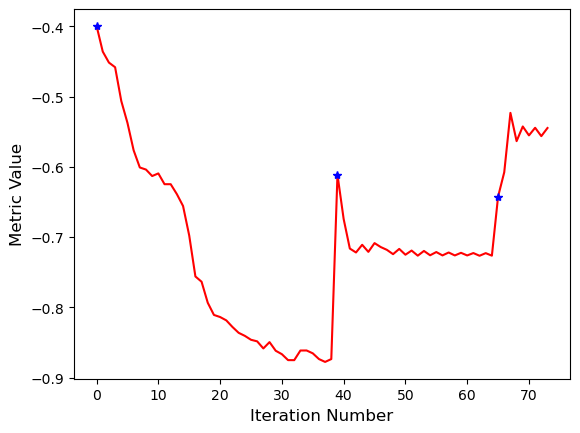

In [11]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
final_transform = registration_method.Execute(
    sitk.Cast(fixed_image, sitk.sitkFloat32), sitk.Cast(moving_image, sitk.sitkFloat32)
)

In [12]:
print(f"Final metric value: {registration_method.GetMetricValue()}")
print(
    f"Optimizer's stopping condition, {registration_method.GetOptimizerStopConditionDescription()}"
)

Final metric value: -0.5542026438971804
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.


In [13]:
moving_resampled = sitk.Resample(
    moving_image,
    fixed_image,
    final_transform,
    sitk.sitkLinear,
    0.0,
    moving_image.GetPixelID(),
)